In [48]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization 
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [49]:
# import all data
df = pd.read_csv('data/upload_DJIA_table.csv', parse_dates=['Date'], index_col='Date')
df = df[['Close']]
df = df.sort_index()

df.head()

,Close
Date,
2008-08-08,11734.320312
2008-08-11,11782.349609
2008-08-12,11642.469727
2008-08-13,11532.959961
2008-08-14,11615.929688


In [50]:
# Train-Test Split 
# Setting 80 percent data for training
training_data_len = math.ceil(len(df) * .8)
training_data_len

#Splitting the dataset
train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)


(1592, 1) (397, 1)


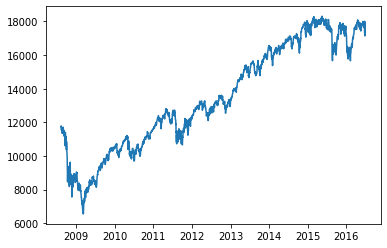

In [3]:
plt.plot(df)

In [55]:
train_data

,Close
Date,
2008-08-08,11734.320312
2008-08-11,11782.349609
2008-08-12,11642.469727
2008-08-13,11532.959961
2008-08-14,11615.929688
...,...
2014-11-26,17827.750000
2014-11-28,17828.240234
2014-12-01,17776.800781


In [57]:
# Selecting Open Price values
dataset_train = train_data.values
dataset_train = np.reshape(dataset_train, (-1,1))

dataset_test = test_data.values
dataset_test = np.reshape(dataset_test, (-1,1))

dataset_test.shape, dataset_train.shape

((397, 1), (1592, 1))

In [58]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)

print(scaled_train[:5])
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5]) #prints the first 5 rows of scaled_test


[[0.45640217]
 [0.46062803]
 [0.44832069]
 [0.43868547]
 [0.44598557]]
[0.84454818] [0.86667668] [0.82659367] [0.80725839] [0.70619221]


In [66]:
# Create sequences and labels for training data
sequence_length = 50 # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
	X_train.append(scaled_train[i:i+sequence_length])
	y_train.append(scaled_train[i+1:i+sequence_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).float()
y_train = torch.tensor(y_train, dtype=torch.float32).float()
X_train.shape,y_train.shape


(torch.Size([1542, 50, 1]), torch.Size([1542, 50, 1]))

In [69]:


# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)
 
# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([367, 30, 1]), torch.Size([367, 30, 1]))

In [70]:
class LSTMModel(nn.Module):
	# input_size : number of features in input at each time step
	# hidden_size : Number of LSTM units 
	# num_layers : number of LSTM layers 
	def __init__(self, input_size, hidden_size, num_layers): 
		super(LSTMModel, self).__init__() #initializes the parent class nn.Module
		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
		self.linear = nn.Linear(hidden_size, 1)

	def forward(self, x): # defines forward pass of the neural network
		out, _ = self.lstm(x)
		out = self.linear(out)
		return out


In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [72]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1

# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)


LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [65]:
X_train.shape

torch.Size([1542, 50, 1])

In [73]:
from torch.utils.data import TensorDataset, DataLoader


batch_size = 16
# Create DataLoader for batch training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for batch training
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [74]:
num_epochs = 50
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
	total_loss = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()

	# Calculate average training loss and accuracy
	average_loss = total_loss / len(train_loader)
	train_hist.append(average_loss)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_test_loss = 0.0

		for batch_X_test, batch_y_test in test_loader:
			batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
			predictions_test = model(batch_X_test)
			test_loss = loss_fn(predictions_test, batch_y_test)

			total_test_loss += test_loss.item()

		# Calculate average test loss and accuracy
		average_test_loss = total_test_loss / len(test_loader)
		test_hist.append(average_test_loss)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [10/50] - Training Loss: 0.0003, Test Loss: 0.0044
Epoch [20/50] - Training Loss: 0.0002, Test Loss: 0.0039
Epoch [30/50] - Training Loss: 0.0001, Test Loss: 0.0038
Epoch [40/50] - Training Loss: 0.0002, Test Loss: 0.0038
Epoch [50/50] - Training Loss: 0.0001, Test Loss: 0.0039


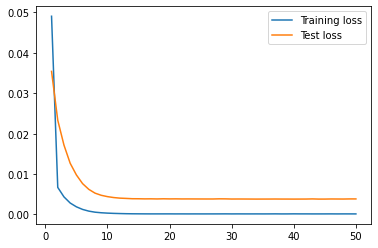

In [75]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()


In [76]:
# Define the number of future time steps to forecast
num_forecast_steps = 30

# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().cpu().numpy()

# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]
print(historical_data.shape)

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
	for _ in range(num_forecast_steps*2):
		# Prepare the historical_data tensor
		historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
		# Use the model to predict the next value
		predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

		# Append the predicted value to the forecasted_values list
		forecasted_values.append(predicted_value[0])

		# Update the historical_data sequence by removing the oldest value and adding the predicted value
		historical_data = np.roll(historical_data, shift=-1)
		historical_data[-1] = predicted_value

		
# Generate futute dates
last_date = test_data.index[-1]

# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

# Concatenate the original index with the future dates
combined_index = test_data.index.append(future_dates)


(30,)


In [80]:
test_data

,Close
Date,
2014-12-04,17900.099609
2014-12-05,17958.789062
2014-12-08,17852.480469
2014-12-09,17801.199219
2014-12-10,17533.150391
...,...
2016-06-27,17140.240234
2016-06-28,17409.720703
2016-06-29,17694.679688


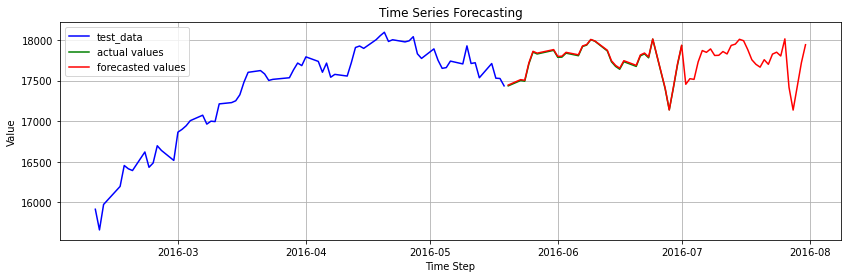

In [84]:
#set the size of the plot 
plt.rcParams['figure.figsize'] = [14, 4] 


#Test data
plt.plot(test_data.index.values[-100:-30], test_data.Close.values[-100:-30], label = "test_data", color = "b") 
#reverse the scaling transformation
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten() 

#the historical data used as input for forecasting
plt.plot(test_data.index.values[-30:], original_cases, label='actual values', color='green') 

#Forecasted Values 
#reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 
# plotting the forecasted values
plt.plot(combined_index.values[-60:], forecasted_cases, label='forecasted values', color='red') 

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
